# Layer-wise Relevance Propagation using Abstract Semiring elements for the MNIST Dataset

In [1]:
import torch
from torch import nn

from torchvision import datasets
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import numpy as np

### Semiring elements

In [2]:
class MultipleInitialisation(Exception):
    pass

class Semiring():
    #value = None

    def __init__(self, relevance=None, activation=None, weight=None, standard=None):
        if relevance is not None:
            self.value = relevance
            if activation is not None or weight is not None or standard is not None:
                raise MultipleInitialisation
        if activation is not None:
            self.value = activation
            if relevance is not None or weight is not None or standard is not None:
                raise MultipleInitialisation
        if weight is not None:
            self.value = weight
            if relevance is not None or activation is not None or standard is not None:
                raise MultipleInitialisation
        if standard is not None:
            self.value = standard
            if relevance is not None or activation is not None or weight is not None:
                raise MultipleInitialisation

    def __mul__(self, b):
        f = self.value * b.value
        s = Semiring()
        s.value = f
        return s
    
    def __add__(self, b):
        f = self.value + b.value
        s = Semiring()
        s.value = f
        return s
    
    def __sub__(self, b):
        f = self.value - b.value
        s = Semiring()
        s.value = f
        return s
    
    def pos(self):
        f = max(0, self.value)
        s = Semiring()
        s.value = f
        return s

    def neg(self):
        f = min(0, self.value)
        s = Semiring()
        s.value = f
        return s
    
from_relevance = np.vectorize(lambda x : Semiring(relevance=x))
from_activation = np.vectorize(lambda x : Semiring(activation=x))
from_weight = np.vectorize(lambda x : Semiring(weight=x))
identity = np.vectorize(lambda x : Semiring(standard=x))
pos = np.vectorize(lambda x : x.pos())
neg = np.vectorize(lambda x : x.neg())

videntity = np.vectorize(identity)

def lower_bound(A):
    return np.vectorize(identity)(A[0]*0-1)
def upper_bound(A):
    return np.vectorize(identity)(A[0]*0+1)

### Load datset

In [3]:
# Load dataset

train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '5')

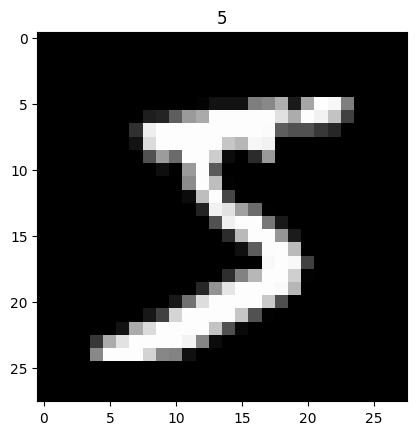

In [4]:
image, label = train[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(label)

In [5]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [6]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

### Train simple model

In [7]:
device = torch.device('mps')

In [8]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

In [9]:
def train_model(model, optimizer, loss_fn):
    torch.manual_seed(42)
    epochs = 1#3

    for epoch in range(epochs):
        print(f"[EPOCH {epoch+1}/{epochs}] ", end="")
        train_loss = 0

        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            model.train()

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            train_loss += loss

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        train_loss /= len(train_dataloader)

        test_loss, test_acc = 0, 0
        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                test_pred = model(X)

                test_loss += loss_fn(test_pred, y)
                test_acc += accuracy_fn(y, test_pred.argmax (dim=1))

            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader)

        print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [10]:
# Build the model
inputs = 784
hidden1 = 300
hidden2 = 100
outputs = 10

assert(outputs == len(train.classes))

model = nn.Sequential(
    nn.Flatten(),
    nn.ReLU(),
    nn.Linear(inputs, hidden1),
    nn.ReLU(),
    nn.Linear(hidden1, hidden2),
    nn.ReLU(),
    nn.Linear(hidden2, outputs)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [11]:
train_model(model, optimizer, loss_fn)

[EPOCH 1/1] Train loss: 0.36054 | Test loss: 0.14701, Test acc: 95.53%


### Layer-wise Relevance Propagation

#### Preparing for LRP

In [12]:
# Extract weights and biases of trained MLP
layers = list(filter(None, [layer if isinstance(layer, nn.Linear) else None for layer in model.children()]))
W = [layer.weight.to('cpu').detach().numpy().T for layer in layers]
B = [layer.bias.to('cpu').detach().numpy().T for layer in layers]
L = len(W)
L

3

In [13]:
W[0].shape, W[1].shape, W[2].shape

((784, 300), (300, 100), (100, 10))

In [14]:
SUBSET = 12

X = train.data.reshape((60000, 784)).detach().numpy()
X = X[:SUBSET]
T = train.targets.detach().numpy()
T = T[:SUBSET]

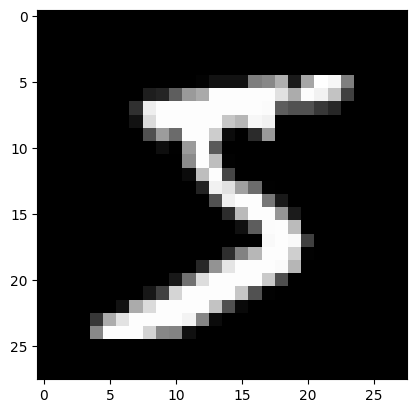

In [15]:
# Test if reshaping went correctly
image = X[0]
plt.imshow(image.reshape((28, 28)), cmap="gray")

In [16]:
# Forward pass
A = [X] + [None] * L
for l in range(L):
    A[l+1] = np.maximum(0, A[l].dot(W[l])+B[l])

In [17]:
i = np.random.randint(0, 10)
prediction = A[L][i]
print(f"Pred: {np.argmax(prediction)} | Label: {train.targets[i]}")

Pred: 3 | Label: 3


#### Actual LRP

In [18]:
nb_digits = len(train.classes)
R = [None] * L + [from_relevance(A[L] * (T[:,None]==np.arange(nb_digits)))]
#R = [None] * L + [A[L]]

General rule for the hidden and output layers:
$$
R^{(l)}_j = \bigoplus_k \Theta_a(a^{(l)}_j) \otimes\Theta_w(w^{(l)}_{jk}) \otimes R^{(l+1)}_k
$$

In [19]:
def rho(w, l):  
    return w #+ [None,0.1,0.0][l] * np.maximum(0,w)
#def incr(z, l): 
#    return z + [None,0.1,0.0][l] * (z**2).mean()**.5+1e-9

Four steps of computing the relevance:
$$
\begin{align*}
\forall k:~z_k &= {\textstyle \epsilon + \sum_{0,j}} a_j \rho(w_{jk}) & (\text{step }1)\\
\forall k:~s_k &= R_k / z_k \qquad & (\text{step }2)\\
\forall j:~c_j &= {\textstyle \sum_k} \rho(w_{jk}) s_k \qquad & (\text{step }3)\\
\forall j:~R_j &= a_j \cdot c_j \qquad & (\text{step }4)
\end{align*}
$$

In [20]:
# All layers except the pixels one
for l in range(1, L)[::-1]:
    w = rho(W[l], l)
    #b = rho(B[l], l)

    #z = incr(A[l].dot(w)+b, l)
    s = R[l+1] #/ z
    c = s.dot(from_weight(w).T)
    R[l] = from_activation(A[l]) * c

$z^\mathcal{B}$ rule for the input layer:
$$R_i = \sum_j \frac{a_i w_{ij} - l_i w_{ij}^+ - h_i w_{ij}^-}{\sum_{i} a_i w_{ij} - l_i w_{ij}^+ - h_i w_{ij}^-} R_j$$

In [32]:
w = from_weight(W[0])
#print(True in [any(not isinstance(y, Semiring) for y in x) for x in from_weight(W[0])])
#wp = pos(w)
#wm = neg(w)
#lb = lower_bound(A)
#hb = upper_bound(A)

#z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9
s = from_relevance(R[1])#/z
c = s.dot(w.T)
#cp = s.dot(wp.T)
#cm = s.dot(wm.T)
#
#p1 = from_activation(A[0])*c
#p2 = lb*cp
#p3 = hb*cm
#
#R[0] =  p1 - p2 - p3

AttributeError: 'float' object has no attribute 'value'

In [22]:
for i in range(10):
    image = R[0][i].reshape((28, 28))

    b = 10*(np.abs(image)**3.0).mean()**(1.0/3)

    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:,0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    fig, axs = plt.subplots(1, 2)

    axs[0].imshow(X[i].reshape((28, 28)), cmap="gray")
    axs[1].imshow(image,cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
    plt.show()

TypeError: 'NoneType' object is not subscriptable